# DEMO 

Read in the intake catalogues of the BARRA dataset from the input to bias correction
and setup the calculation of ffdi


#### required packages

In [1]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime

from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)


#### start a local Dask client

In [2]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

from dask.distributed import Client
client = Client()
client

2024-06-28 20:45:45,578 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-28 20:45:45,585 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-28 20:45:45,594 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/8787/status,
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37271,Workers: 32
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36975,Total threads: 1
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/36095/status,Memory: 0 B
Nanny: tcp://127.0.0.1:36013,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Obtain the desired catalogues of the simulations to processe

In [4]:
catalogue_path='/g/data/ia39/catalogues'
#catalogue_path='/g/data/xv83/rxm599/acs/data_catalogues/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*BARRA*.json'))
print(len(mRuns))

1


# Process one ensemble 

In [5]:
# From one catalogue list save variables
mindex=0  # run to process
cat=intake.open_esm_datastore(mRuns[mindex])
mtmp=mRuns[mindex].split('/')
model_name=mtmp[5].split('.')
print(model_name)
print(cat.unique()['variable']) #unique()['variable']
tmp=model_name[0].split('_'); ACS_model=tmp[1]

['AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day', 'json']
['hursmax', 'hursmin', 'pr', 'rsds', 'sfcWindmax', 'tasmax', 'tasmin']


In [6]:
%%time
# read in a few variables from one member
#)#,'tasmax','hursmin'})#,'sfcWindmax'})
#cat_subset=cat.search(variable={'pr'})#,'tasmax','hursmin'})#,'sfcWindmax'})
pr = cat.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
tasmax = cat.search(variable={'tasmax'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
hursmin = cat.search(variable={'hursmin'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
sfcWindmax = cat.search(variable={'sfcWindmax'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})

CPU times: user 31 s, sys: 5.43 s, total: 36.4 s
Wall time: 1min 7s


In [7]:
sfcWindmax

<xarray.Dataset>
Dimensions:     (time: 16436, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T12:0...
  * lat         (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon         (lon) float64 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
  * bnds        (bnds) float64 0.0 1.0
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
Data variables:
    sfcWindmax  (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                         CF-1.10, ACDD-1.3
    activity_id:                         reanalysis
    title:                               Pre-processed model output in prepar...
    source:                              Data from Met Office Unified Model (...
    project:                             BARRA2
    program:                             Australian Climate Service (ACS)
    ...                                  ...
    intake_esm_attrs:downscale_model:    BOM
    intake_esm_attrs:downscale_version:  BARRA-R2
    intake_esm_attrs:period:             v1
    intake_esm_attrs:time_period:        fixed
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AGCD-05i.ERA5.historical.hres.BOM.BA...

In [8]:
# hursmin has a different time axis than the other variables!
# could do two seperate datasets to deal with the different tima axis but not doing now.
hursmin=hursmin.assign_coords(time= pr.time)

# BoM files have height coordinate in the sfcWindmax that needs to be removed
if ACS_model == 'BOM':
#    sfcWindmax=sfcWindmax.reset_coords('height', drop=True)
#    tasmax=tasmax.reset_coords('height', drop=True)
#    hursmin=hursmin.reset_coords({'height','level_height','model_level_number','sigma'}, drop=True)
     print(ACS_model)

hursmin

BOM


<xarray.Dataset>
Dimensions:    (lat: 691, lon: 886, time: 16436, bnds: 2)
Coordinates:
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T12:00:00
Dimensions without coordinates: bnds
Data variables:
    hursmin    (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                         CF-1.10, ACDD-1.3
    activity_id:                         reanalysis
    title:                               Pre-processed model output in prepar...
    source:                              Data from Met Office Unified Model (...
    project:                             BARRA2
    program:                             Australian Climate Service (ACS)
    ...                                  ...
    intake_esm_attrs:downscale_model:    BOM
    intake_esm_attrs:downscale_version:  BARRA-R2
    intake_esm_attrs:period:             v1
    intake_esm_attrs:time_period:        fixed
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AGCD-05i.ERA5.historical.hres.BOM.BA...

## Calculate FFDI 

In [9]:
%%time
# This is usually computed over a specific period
pr_annual = pr.pr.resample(time="Y").sum().\
    sel(time=slice('1985-01-01', '2015-01-01')).mean("time").\
    assign_attrs(
    units="mm a-1", long_name="Annual average rainfall")

pr_annual

CPU times: user 377 ms, sys: 58.6 ms, total: 435 ms
Wall time: 504 ms


<xarray.DataArray 'pr' (lat: 691, lon: 886)>
dask.array<mean_agg-aggregate, shape=(691, 886), dtype=float32, chunksize=(691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
Attributes:
    units:      mm a-1
    long_name:  Annual average rainfall

In [10]:
t1='2015-01-01'; t2='2015-12-31'
pra=pr.pr.sel(time=slice(t1, t2))
tasmaxa=tasmax.tasmax.sel(time=slice(t1,t2))
hursmina=hursmin.hursmin.sel(time=slice(t1,t2))
sfcWindmaxa=sfcWindmax.sfcWindmax.sel(time=slice(t1,t2))
#pra,tasmaxa,hursmina,sfcWindmaxa

In [12]:
dnew=xr.merge([pr,tasmax,hursmin,sfcWindmax], compat='override')
dnew

<xarray.Dataset>
Dimensions:     (time: 16436, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T12:0...
  * lat         (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon         (lon) float64 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
  * bnds        (bnds) float64 0.0 1.0
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
Data variables:
    pr          (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
    tasmax      (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
    hursmin     (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
    sfcWindmax  (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                         CF-1.10, ACDD-1.3
    activity_id:                         reanalysis
    title:                               Pre-processed model output in prepar...
    source:                              Data from Met Office Unified Model (...
    project:                             BARRA2
    program:                             Australian Climate Service (ACS)
    ...                                  ...
    intake_esm_attrs:downscale_model:    BOM
    intake_esm_attrs:downscale_version:  BARRA-R2
    intake_esm_attrs:period:             v1
    intake_esm_attrs:time_period:        fixed
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AGCD-05i.ERA5.historical.hres.BOM.BA...

In [15]:
KBDI = keetch_byram_drought_index(pra, tasmaxa, pr_annual) 
DF = griffiths_drought_factor(pra, KBDI)
FFDI = mcarthur_forest_fire_danger_index(DF, tasmaxa, hursmina, sfcWindmaxa)
ds = FFDI.to_dataset(name='FFDI')

In [16]:
%%time
#FFDI.to_netcdf('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.nc')
ds.to_zarr('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.zar',mode='w')

CPU times: user 45.8 s, sys: 13.4 s, total: 59.2 s
Wall time: 1min 58s


# The End  added some extra plotting to check the input info

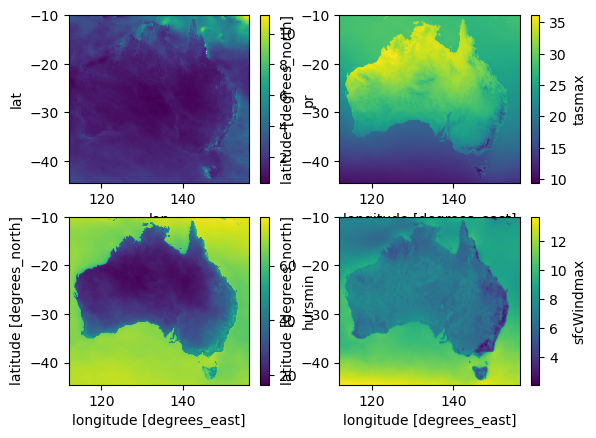

In [17]:
plt.subplot(2,2,1); pra.mean('time').plot()
plt.subplot(2,2,2); tasmaxa.mean('time').plot()
plt.subplot(2,2,3); hursmina.mean('time').plot()
plt.subplot(2,2,4); sfcWindmaxa.mean('time').plot()

In [18]:
ds=xr.open_zarr('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.zar')
#ffdi=xr.open_zarr('/g/data/ia39/ncra/fire/'+'AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zar')
ds

0.3.0


<xarray.Dataset>
Dimensions:  (lat: 691, lon: 886, time: 365)
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
Data variables:
    FFDI     (lat, lon, time) float32 dask.array<chunksize=(691, 886, 365), meta=np.ndarray>

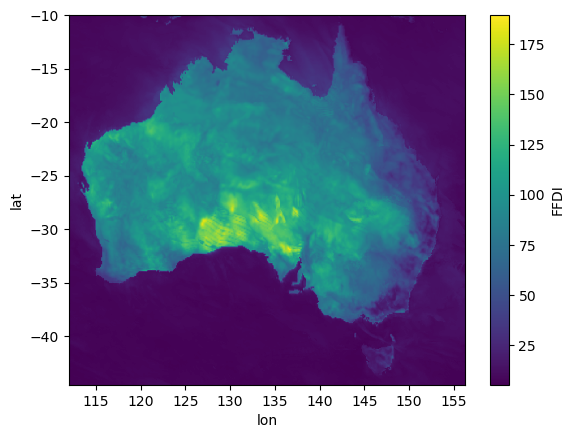

In [20]:
#ds.FFDI.max('time').plot()
ds.FFDI.isel(time=slice(19,None)).max('time',skipna=False).plot()

In [21]:
client.shutdown()

0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
